In [48]:
from AOSCMcoupling import OIFSPreprocessor, NEMOPreprocessor, OASISPreprocessor
import xarray as xr
import proplot as pplt
import pandas as pd
from pathlib import Path
import numpy as np
import warnings

In [49]:
dates = pd.date_range("2020-04-12 00:00", "2020-04-18 22:00", freq="2h")
max_iters = 30
tldir = Path("/Users/valentina/dev/aoscm/aoscm-experiments/output/top_ensemble_full")
assert(tldir.is_dir())

In [50]:
def get_date_dirs(dates: pd.DatetimeIndex) -> list[Path]:
    date_dirs = [tldir / f"{date.date()}_{date.hour:02}" for date in dates]
    for date_dir in date_dirs:
        assert(date_dir.is_dir())
    return date_dirs

In [51]:
def load_single_iteration_results(dates: pd.DatetimeIndex, iter: int, file_name: str, preprocess: list[callable]) -> xr.Dataset:
    date_dirs = get_date_dirs(dates)
    start_date_dim = xr.DataArray(dates, dims="start_date")
    date_files = []
    for date_dir, preproc in zip(date_dirs, preprocess):
        file = date_dir / f"iter_{iter}/{file_name}"
        ds = xr.open_mfdataset(str(file), preprocess=preproc)
        date_files.append(ds)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        concatenated_ds = xr.concat(date_files, start_date_dim)
    return concatenated_ds

In [52]:
def load_std(dates: pd.DatetimeIndex, file_name: str, preprocess: list[callable], iter_range: range) -> xr.Dataset:
    date_dirs = get_date_dirs(dates)
    swr_dim = xr.DataArray(np.array(iter_range), dims="swr_iterate")
    start_date_dim = xr.DataArray(dates, dims="start_date")
    stds = []
    for date_dir, preproc in zip(date_dirs, preprocess):
        files = [date_dir / f"iter_{iter + 1}/{file_name}" for iter in iter_range]
        iterates = [
            xr.open_mfdataset(str(file), preprocess=preproc)
            for file in files
        ]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            std = xr.concat(iterates, swr_dim).std("swr_iterate")
        stds.append(std)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        concatenated_ds = xr.concat(stds, start_date_dim)
    return concatenated_ds

In [53]:
oifs_preproc = [OIFSPreprocessor(date).preprocess for date in dates]
progvar = load_single_iteration_results(dates, 1, "progvar.nc", oifs_preproc)

In [54]:
nemo_preproc = [NEMOPreprocessor(date).preprocess for date in dates]
icemod = load_single_iteration_results(dates, 30, "*icemod*.nc", nemo_preproc)

In [55]:
progvar_std = load_std(dates, "progvar.nc", oifs_preproc, range(20, 30))

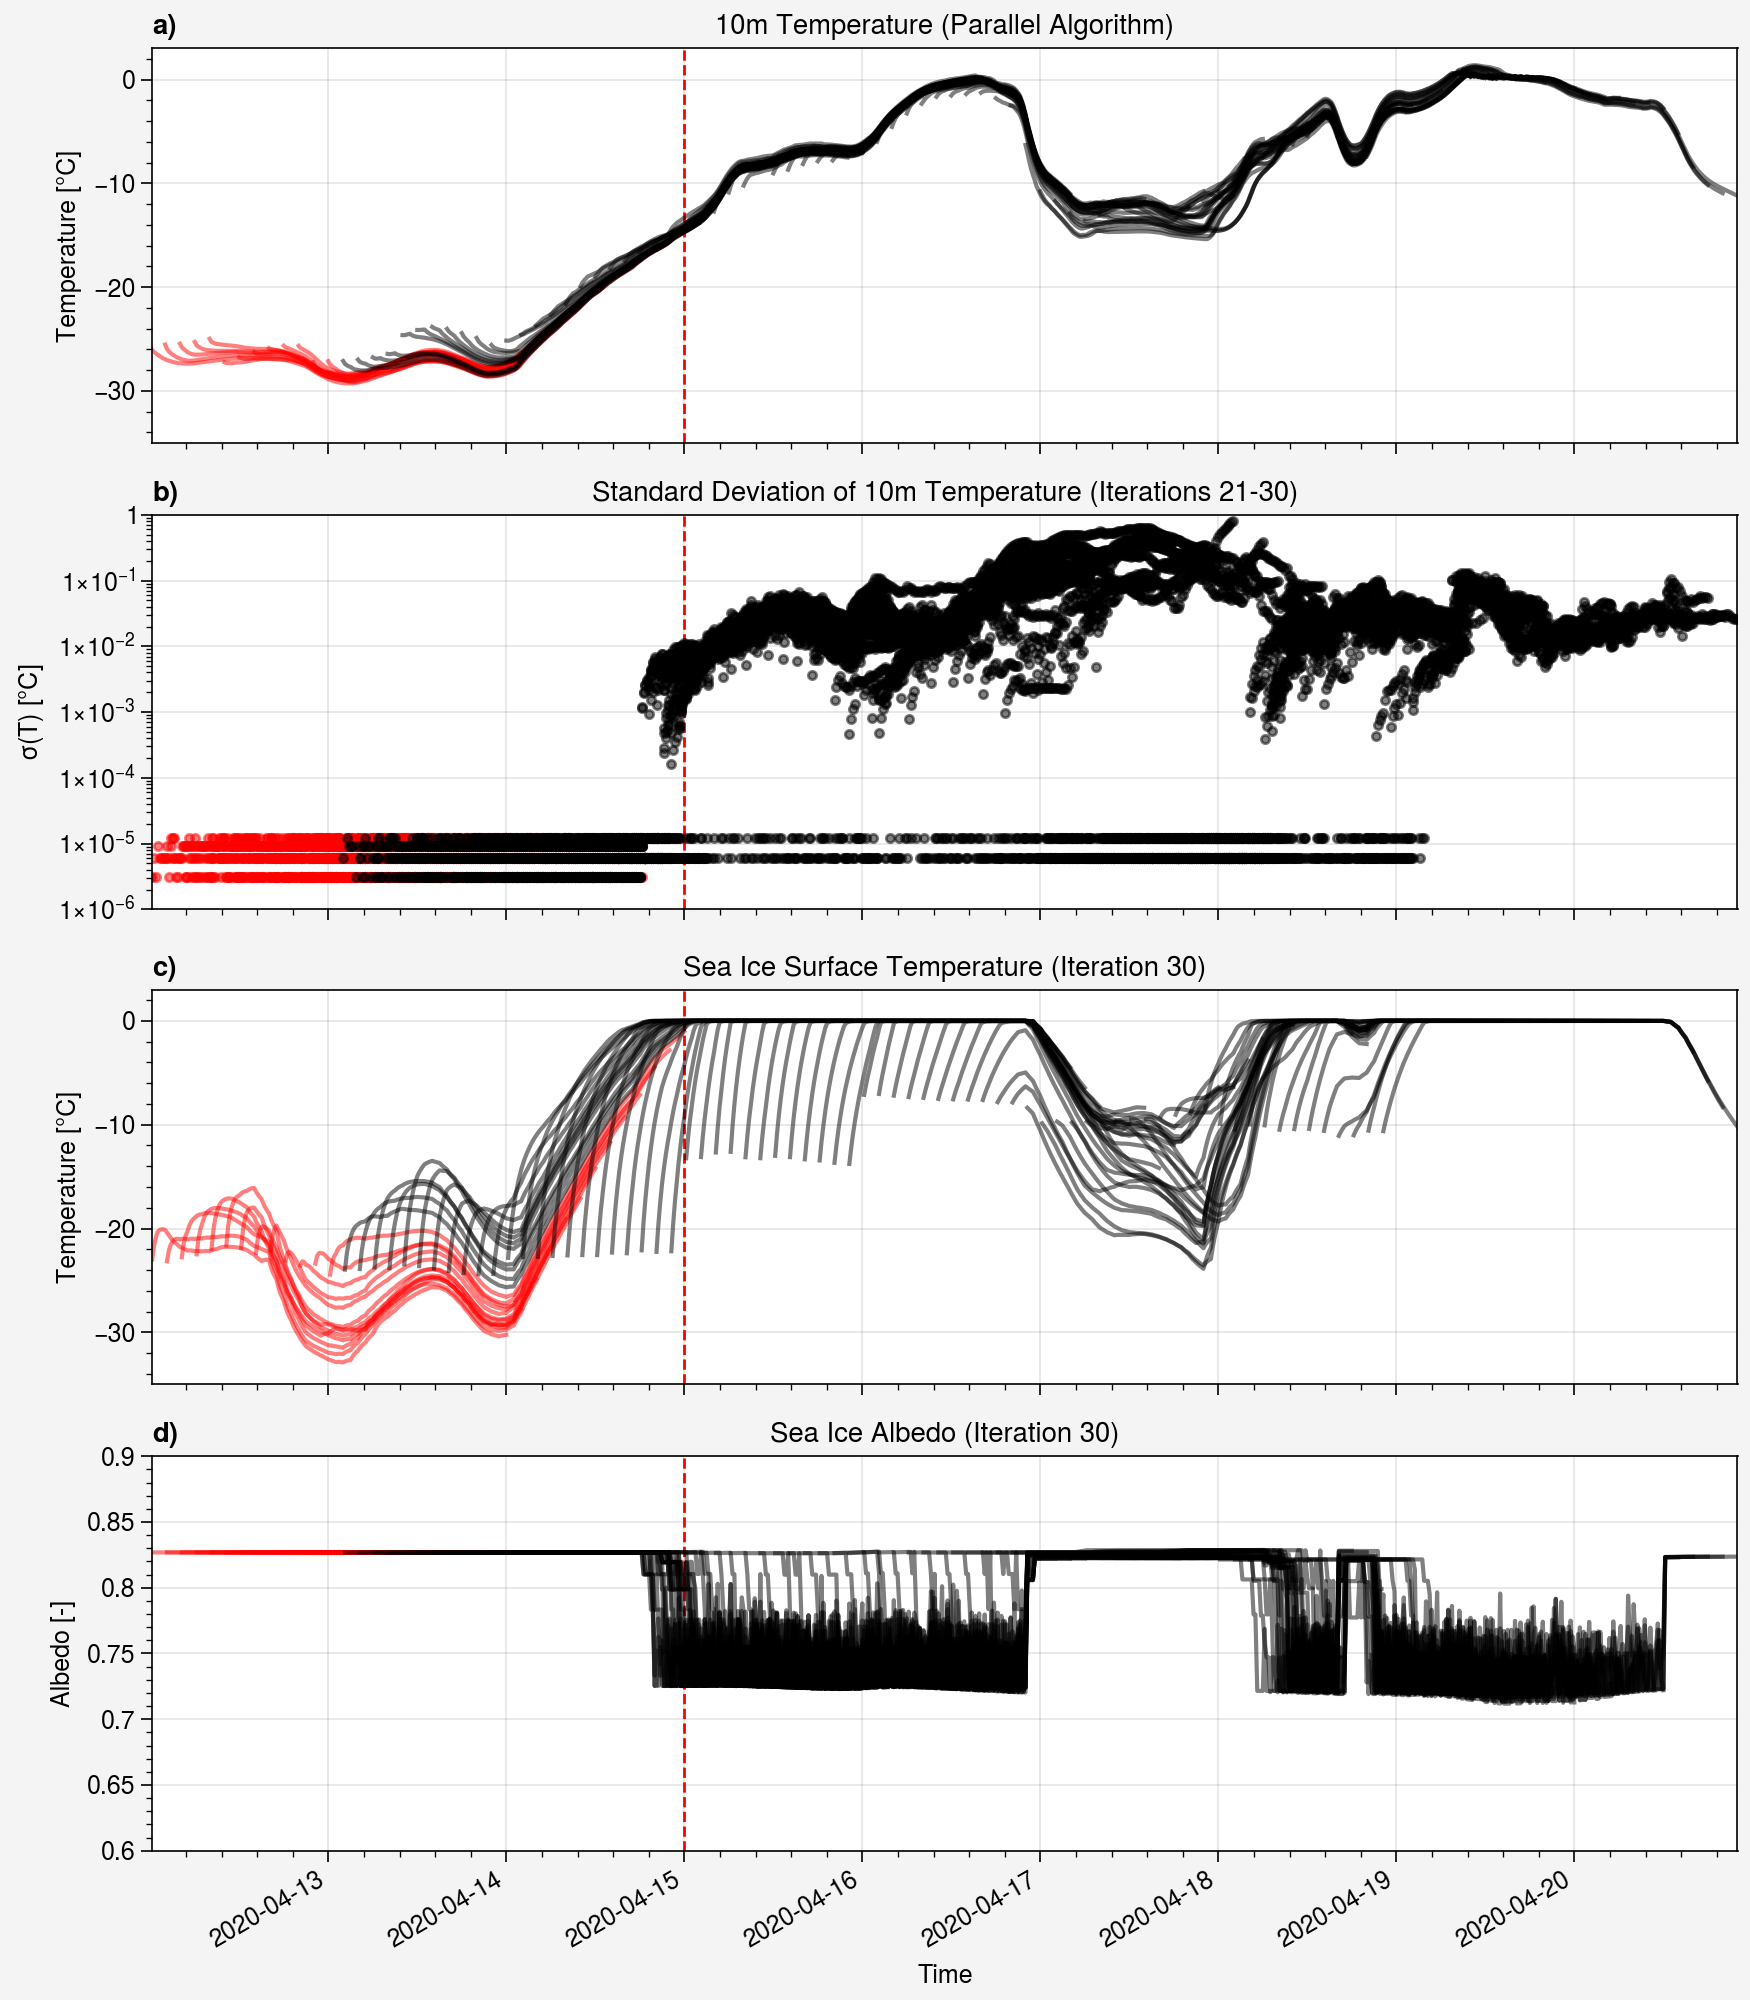

In [60]:
fig, axs = pplt.subplots(width="70em", height="80em", nrows=4, ncols=1, sharey=0, sharex=3)

ax = axs[0]
t10 = progvar.t.isel(nlev=-1) - 273.15
for index in range(len(t10.start_date)):
    if index < 13:
        color="r"
    else:
        color="k"
    ax.plot(t10[index], color=color, alpha=0.5)

vmin, vmax = -35, 3
ax.vlines(np.datetime64(t10[12].start_date.data + pd.Timedelta("2d")), vmin, vmax, color="r", ls="--", lw=1)
ax.format(
    xlabel="Time",
    ylabel="Temperature [°C]",
    xrotation=30,
    title="10m Temperature (Parallel Algorithm)",
    ylim=[vmin, vmax],
)

ax = axs[1]
t10_std = progvar_std.t.isel(nlev=-1)
for index in range(len(t10.start_date)):
    if index < 13:
        color="r"
    else:
        color="k"
    ax.plot(t10_std[index], color=color, alpha=0.5, marker=".", ls="none")
vmin, vmax = 1e-6, 1
ax.vlines(np.datetime64(icemod.start_date[12].data + pd.Timedelta("2d")), vmin, vmax, color="r", ls="--", lw=1)
ax.format(
    xlabel="Time",
    ylabel="$\sigma(T)$ [°C]",
    xrotation=30,
    yscale="log",
    yformatter="sci",
    ylim=[vmin, vmax],
    title="Standard Deviation of 10m Temperature (Iterations 21-30)",
)

ax = axs[2]
for index in range(len(icemod.start_date)):
    if index < 13:
        color="r"
    else:
        color="k"
    ax.plot(icemod.icettop[index], color=color, alpha=0.5)

vmin, vmax = -35, 3
ax.vlines(np.datetime64(icemod.start_date[12].data + pd.Timedelta("2d")), vmin, vmax, color="r", ls="--", lw=1)
ax.format(
    xlabel="Time",
    ylabel="Temperature [°C]",
    xrotation=30,
    title="Sea Ice Surface Temperature (Iteration 30)",
    ylim=[vmin, vmax],
)

ax = axs[3]

albedo = icemod.iceconc_cat.sel(ncatice=1) * icemod.icealb_cat.sel(ncatice=1)
for category in range(2, 6):
    albedo += icemod.iceconc_cat.sel(ncatice=category) * icemod.icealb_cat.sel(ncatice=category)

for index in range(len(albedo.start_date)):
    if index < 13:
        color="r"
    else:
        color="k"
    ax.plot(albedo[index], color=color, alpha=0.5)
vmin, vmax = 0.6, 0.9
ax.vlines(np.datetime64(albedo.start_date[12].data + pd.Timedelta("2d")), vmin, vmax, color="r", ls="--", lw=1)
ax.format(
    xlabel="Time",
    ylabel="Albedo [-]",
    xrotation=30,
    title="Sea Ice Albedo (Iteration 30)",
    ylim=[vmin, vmax],
)

axs.format(abc="a)")

fig.savefig("top_ensemble_ece4.pdf")


In [57]:
albedo.mean().load()

<xarray.DataArray ()>
array(0.78756374, dtype=float32)
Coordinates:
    ncatice  float32 1.0
    nav_lon  float32 -145.0
    nav_lat  float32 50.0